In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Oct 10 14:09:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from easydict import EasyDict
from collections import OrderedDict


class GroupEnsembleBlock(nn.Module):
    def __init__(self, input_length=2048, output_length=512,
                 group_num=32, subspace_total=1024, parallel_trans='linear'):
        super(GroupEnsembleBlock, self).__init__()
        self.group_num = group_num
        self.subspace_total = subspace_total
        self.mask_len = input_length // group_num
        if parallel_trans == 'linear':
            self.parallel_trans = nn.Linear(self.mask_len, output_length // group_num)
        elif parallel_trans == 'MLP':
            inter = output_length // group_num
            self.parallel_trans = nn.Sequential(OrderedDict([
                ('linear1', nn.Linear(self.mask_len, inter)),
                ('relu1', nn.ReLU()),
                ('linear2', nn.Linear(inter, inter)),
                ('relu2', nn.ReLU()),
                ('linear3', nn.Linear(inter, output_length // group_num),)]))
        else:
            print('unsupported parallel transformation')

        self.bn_after_cat = nn.BatchNorm1d(output_length)
        self.mask_pos = torch.nn.Parameter(data=torch.randint(high=input_length, size=(self.subspace_total * self.mask_len,)),
                                           requires_grad=False)
        self.float_mask = torch.nn.Parameter(data=torch.Tensor(1, group_num, self.subspace_total // group_num,
                                             self.mask_len), requires_grad=False)
        self.float_mask.data.uniform_(0, 1)
        self.tau = 0.1

        print("Parameters in group ensemble block:")
        print("self.mean_num ", group_num)
        print("self.mask_num ", subspace_total)
        print("self.mask_len", self.mask_len)
        print("Sampled elements amount,", len(list(set(self.mask_pos.tolist()))))
        print("self.mask_pos.is_leaf", self.float_mask.is_leaf)
        print("Using float mask")
        print("tau for masking b_n", self.tau)

    def forward(self, x):
        x = torch.index_select(x, dim=-1, index=self.mask_pos)
        x = x.view(x.shape[0], self.group_num, self.subspace_total // self.group_num, self.mask_len)
        x = x * F.relu(self.float_mask - self.tau) / (1.0 - self.tau)
        x = self.parallel_trans(x)
        x = torch.mean(x, dim=2)
        x = x.view(x.shape[0], -1)
        x = self.bn_after_cat(x)
        return x

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_classes)
        
        self.linear = GroupEnsembleBlock(input_length=512*block.expansion, 
                                         output_length=10, group_num=10, 
                                         subspace_total=100)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [ ]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
from easydict import EasyDict
import datetime

args = EasyDict({'lr': 0.1,
                 'resume': False})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = ResNet50()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    print("Learning rate{}".format(optimizer.param_groups[0]['lr']))
    print(datetime.datetime.now())
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0 or batch_idx == len(trainloader) - 1:
            print('Epoch: [{}][{}/{}]\t'
                  'Average Loss: {:.6f}\t'
                  'Average acc: {:.6f}\t'.format(
                  epoch, batch_idx, len(trainloader),
                  train_loss/(batch_idx+1),
                  100.*correct/total))
    return train_loss, 100.*correct/total


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    print('current acc {:.6f} and best acc {:.6f}'.format(acc, best_acc))
    return test_loss, acc


records = []
for epoch in range(start_epoch, start_epoch+200):
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)
    scheduler.step()
    records.append([train_loss, train_acc, test_loss, test_acc])

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
Parameters in group ensemble block:
self.mean_num  10
self.mask_num  100
self.mask_len 204
Sampled elements amount, 2048
self.mask_pos.is_leaf True
Using float mask
tau for masking b_n 0.1

Epoch: 0
Learning rate0.1
2022-10-10 14:32:50.355432
Epoch: [0][0/196]	Average Loss: 2.371496	Average acc: 9.765625	
Epoch: [0][100/196]	Average Loss: 2.004178	Average acc: 25.386757	
Epoch: [0][195/196]	Average Loss: 1.787405	Average acc: 33.764000	
Saving..
current acc 45.940000 and best acc 45.940000

Epoch: 1
Learning rate0.09999383162408304
2022-10-10 14:35:30.777099
Epoch: [1][0/196]	Average Loss: 1.369686	Average acc: 52.734375	
Epoch: [1][100/196]	Average Loss: 1.343057	Average acc: 51.469678	
Epoch: [1][195/196]	Average Loss: 1.274862	Average acc: 54.260000	
Saving..
current acc 57.560000 and best acc 57.560000

Epoch: 2
Learning rate0.09997532801828658
2022-10-10 14:38:10.9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 7.5), dpi=100)

linewidth = 2.5
fs = 15

plt.plot(train_accs_baseline, c='darkorange', linewidth=linewidth)
plt.plot(test_accs_baseline, c='darkorange', linewidth=linewidth, linestyle='-.')

plt.plot(train_accs_ensemble, c='royalblue', linewidth=linewidth)
plt.plot(test_accs_ensemble, c='royalblue', linewidth=linewidth, linestyle='-.')

x_ticks_range = np.arange(0, 201, 50)
y_ticks_range = np.arange(0, 101, 20)
plt.xticks(x_ticks_range, fontsize=fs)
plt.yticks(y_ticks_range, fontsize=fs)
plt.xlabel('Epoch', fontsize=fs)
plt.ylabel('Accuracy', fontsize=fs)

plt.legend(['Training accuracy of ResNet50',
            'Testing accuracy of ResNet50',
            'Training accuracy of ResNet50 with our group ensemble block',
            'Testing accuracy of ResNet50 with our group ensemble block',],
           fontsize=13);

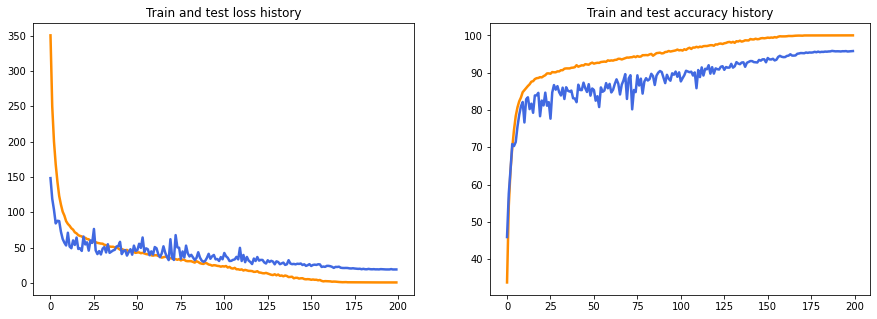

In [22]:
import numpy as np
import matplotlib.pyplot as plt


train_losses = [item[0] for item in records]
train_acces = [item[1] for item in records]
test_losses = [item[2] for item in records]
test_acces = [item[3] for item in records]

linewidth = 2.5
fs = 15
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, c='darkorange', linewidth=linewidth)
ax1.plot(test_losses, c='royalblue', linewidth=linewidth)
ax1.set_title('Train and test loss history')

ax2.plot(train_acces, c='darkorange', linewidth=linewidth)
ax2.plot(test_acces, c='royalblue', linewidth=linewidth)
ax2.set_title('Train and test accuracy history');